# Sampling from a GP

## Preliminary steps

### Loading necessary packages

In [1]:
using Plots
using AugmentedGaussianProcesses
using Distributions
using LinearAlgebra

### Loading the banana dataset from OpenML

In [2]:
kernel = SqExponentialKernel()
x = range(0, 10, length=50)
K = kernelmatrix(kernel, x)
f = rand(MvNormal(K + 1e-8I)) # Sample a random GP
y = rand.(Bernoulli.(AGP.logistic.(f)))
y_sign = sign.(y .- 0.5)

50-element Vector{Float64}:
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
  1.0
 -1.0
  ⋮
  1.0
 -1.0
  1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0
 -1.0

### We create a function to visualize the data

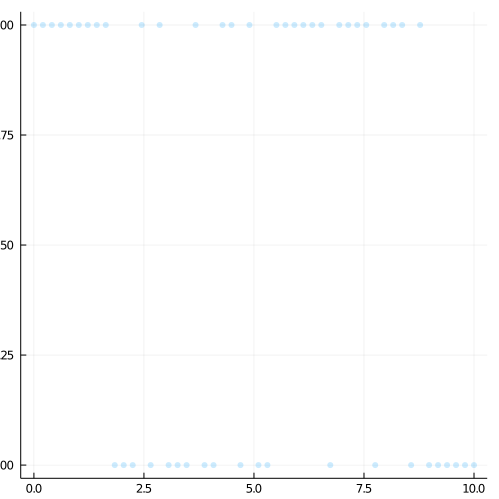

In [3]:
function plot_data(x, y; size=(300,500))
    Plots.scatter(x,
                y,
                alpha=0.2,
                markerstrokewidth=0.0,
                lab="",
                size=size
            )
end
plot_data(x, y; size = (500, 500))

### Run the variational gaussian process approximation

In [4]:
@info "Running full model"
mfull = VGP(x, y_sign,
            kernel,
            LogisticLikelihood(),
            AnalyticVI(),
            optimiser = false
            )
@time train!(mfull, 5)

┌ Info: Running full model
└ @ Main.##475 string:1
  0.619673 seconds (1.13 M allocations: 66.038 MiB, 99.40% compilation time)


### We can also create a sampling based model

In [5]:
@info "Sampling from model"
mmcmc = MCGP(x, y,
            kernel,
            LogisticLikelihood(),
            GibbsSampling(),
            optimiser = false
            )
m = mmcmc
@time samples = sample(mmcmc, 1000)

┌ Info: Sampling from model
└ @ Main.##475 string:1
Sampling with Gibbs Sampler   0%|                       |  ETA: N/A
Sampling with Gibbs Sampler   0%|▏                      |  ETA: 0:05:35
Sampling with Gibbs Sampler   1%|▎                      |  ETA: 0:02:50
Sampling with Gibbs Sampler   1%|▍                      |  ETA: 0:01:53
Sampling with Gibbs Sampler   2%|▍                      |  ETA: 0:01:24
Sampling with Gibbs Sampler   2%|▌                      |  ETA: 0:01:07
Sampling with Gibbs Sampler   3%|▋                      |  ETA: 0:00:56
Sampling with Gibbs Sampler   3%|▊                      |  ETA: 0:00:48
Sampling with Gibbs Sampler   4%|▉                      |  ETA: 0:00:42
Sampling with Gibbs Sampler   4%|█                      |  ETA: 0:00:37
Sampling with Gibbs Sampler   5%|█                      |  ETA: 0:00:33
Sampling with Gibbs Sampler   5%|█▏                     |  ETA: 0:00:30
Sampling with Gibbs Sampler   5%|█▎                     |  ETA: 0:00:27
Sampling with Gi

1000-element Vector{Vector{Vector{Float64}}}:
 [[-0.18385582874687056, -0.2612461696201662, -0.169825799732652, 0.011715690229799458, 0.25577794312062385, 0.5415515507956514, 0.7539788529458393, 0.8777298229603223, 0.8876952517131724, 0.7857955444095583  …  0.2187576869433111, -0.17082324154548784, -0.5484898200949488, -0.9005606924223162, -1.2289377096506864, -1.4959767795152223, -1.6813303568393019, -1.735736129842362, -1.6538837892774214, -1.4700334350053166]]
 [[1.4778888991779822, 1.485574788182192, 1.4272639083036809, 1.2556680335645725, 1.0553218764679628, 0.8119785314736219, 0.5628670555864691, 0.36647498454059213, 0.17982766382205673, 0.053037353591959935  …  -0.14596413817658427, -0.36976418030610203, -0.5743141553508538, -0.7280065714253464, -0.8777781213132386, -0.9730826215532656, -1.0678118528647211, -1.163207351209221, -1.2205734988695578, -1.256301482902018]]
 [[-0.023177766543636347, 0.15972181860590617, 0.2992484053603277, 0.37331566525324844, 0.33025472055058236, 0.2

### We can now visualize the results of both models

### We first plot the latent function f (truth, the VI estimate, the samples)

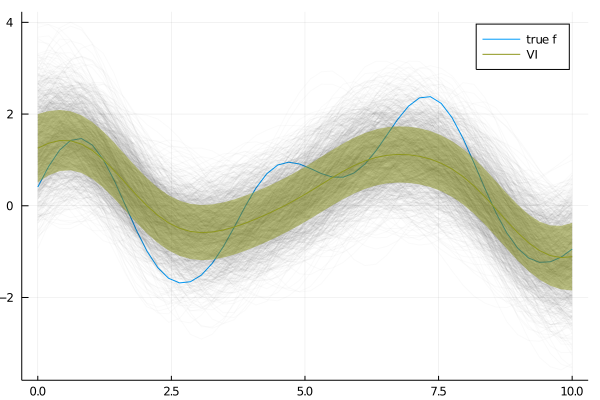

In [6]:
p1 = plot(x, f, label="true f")
plot!(x, samples, label="", color=:black, alpha=0.02, lab="")
plot!(x, mean(mfull[1]), ribbon=sqrt.(var(mfull[1])), label="VI")

### And we can also plot the predictions vs the data

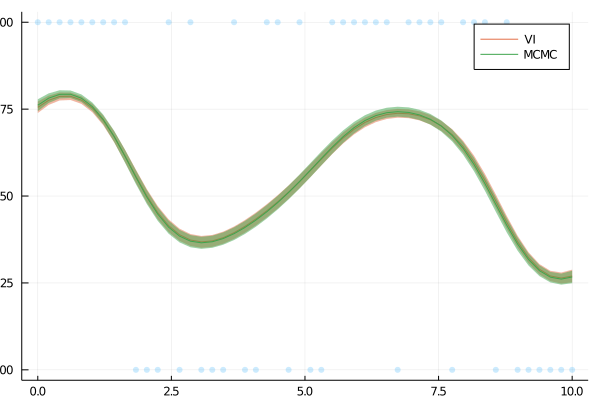

In [7]:
p2 = plot_data(x, y; size=(600,400))
μ_vi, σ_vi = proba_y(mfull, x)
plot!(x, μ_vi; ribbon=σ_vi, label="VI")
μ_mcmc, σ_mcmc = proba_y(mmcmc, x)
plot!(x, μ_mcmc; ribbon=σ_mcmc, label="MCMC")

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*